# Evaluation of Suzuki Coupling and Kinetic Models

# Setup

In [9]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
from summit import *
from multitask import *


from rdkit import Chem

import torch

import pathlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import List
from IPython.display import clear_output
from copy import deepcopy
from pathlib import Path
import json
import os

In [11]:
def make_average_plot(results: List[Experiment], ax, label=None, color=None):
    objective = results[0].domain.output_variables[0].name
    yields = [r.data[objective] for r in results]
    yields = np.array(yields)
    mean_yield = np.mean(yields, axis=0)
    std_yield = np.std(yields, axis=0)
    x = np.arange(0, len(mean_yield), 1).astype(int)
    ax.plot(x, mean_yield, label=label, linewidth=4, c=color)
    ax.fill_between(x, mean_yield-1.96*std_yield, mean_yield+1.96*std_yield, alpha=0.1, color=color)
    
def make_repeats_plot(results: List[Experiment], ax, label=None, color=None):
    objective = results[0].domain.output_variables[0].name
    yields = [r.data[objective] for r in results]
    x = np.arange(0, len(yields[0]), 1).astype(int)
    line = ax.plot(x, yields[0], label=label, linewidth=2,alpha=0.25, c=color, solid_capstyle="round")
    for data in yields[1:]:
        line = ax.plot(x, data, linewidth=2,alpha=0.25, c=color, solid_capstyle="round")

def make_comparison_plot(*args, ax=None, plot_type="average"):
    if ax is None:
        fig, ax = plt.subplots(1)
    for arg in args:
        if plot_type == "average":
            make_average_plot(arg['results'], ax, label=arg["label"], color=arg.get("color"))
        elif plot_type == "repeats":
            make_repeats_plot(arg['results'], ax, label=arg["label"], color=arg.get("color"))
        else:
            raise ValueError(f"{plot_type} must be average or repeats")
    fontdict = fontdict={"size":12}
    if plot_type == "average":
        ax.legend(prop=fontdict, framealpha=0.0)
    else:
        ax.legend(prop=fontdict)
    ax.set_xlim(0,20)
    ax.set_xticks(np.arange(0, 20, 2).astype(int))
    ax.tick_params(direction='in')
    return ax

def remove_frame(ax, sides=["top", "left", "right"]):
    for side in sides:
        ax_side = ax.spines[side]
        ax_side.set_visible(False)

In [12]:
# Put Utopia Std in the data/ folder in your fonts library
# On mac this is ~/Library/Fonts
# Run this a couple times if you get an error the first time
from matplotlib import font_manager
font_manager.findfont("Utopia Std", fontext="afm", rebuild_if_missing=True)
plt.rcParams.update({
    "font.family": "serif",
    # Use LaTeX default serif font.
    "font.serif": ["Utopia Std"],
})

findfont: Font family ['Utopia Std'] not found. Falling back to Helvetica.


In [13]:
for f in font_manager.fontManager.ttflist:
    if "Utopia" in f.name:
        print(f)

FontEntry(fname='/Users/Kobi/Library/Fonts/UtopiaStd-Regular.ttf', name='Utopia Std', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')


# Suzuki Cross Coupling

## Load Suzuki Data

In [44]:
#Multitask 
multitask_path = pathlib.Path("../data/multitask_results")
multitask_dirs = multitask_path.glob("*")
all_experiments = {}
for multitask_dir in multitask_dirs:
    json_files  = multitask_dir.glob("*.json")
    experiments = []
    for json_file in json_files:
        with open(json_file, "r") as f:
            runner_dict = json.load(f)
            experiments.append(ExperimentalEmulator.from_dict(runner_dict["experiment"]))
    name = multitask_dir.parts[-1]
    all_experiments[name] = experiments

In [15]:
n=0
tbar=0
for exps in all_experiments.values():
    times = np.mean([exp.data['computation_t'].sum() for exp in exps])
    if np.isnan(times):
        continue
    n+=1
    tbar = times/n+(n-1)/n*tbar
print(f"Average time for multitask optimization {tbar / 60:.01f} minutes")

Average time for multitask optimization 2.6 minutes


/Users/Kobi/Library/Caches/pypoetry/virtualenvs/multitask-k0YbXS9f-py3.9/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/Kobi/Library/Caches/pypoetry/virtualenvs/multitask-k0YbXS9f-py3.9/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [16]:
# Baugmartner STBO
baumgartner_results_path = Path("../data/baumgartner_suzuki/results_stbo")
json_files  = baumgartner_results_path.glob("*.json")
all_experiments_baumgartner_stbo = []
for json_file in json_files:
    with open(json_file, "r") as f:
        runner_dict = json.load(f)
        all_experiments_baumgartner_stbo.append(ExperimentalEmulator.from_dict(runner_dict["experiment"]))

In [17]:
# Baugmartner STBO Mixed
baumgartner_results_path = Path("../data/baumgartner_suzuki/results_stbo_mixed_domain")
json_files  = baumgartner_results_path.glob("*.json")
all_experiments_baumgartner_stbo_mixed = []
for json_file in json_files:
    with open(json_file, "r") as f:
        runner_dict = json.load(f)
        all_experiments_baumgartner_stbo_mixed.append(ExperimentalEmulator.from_dict(runner_dict["experiment"]))

In [18]:
# Reizman STBO
reizman_path = pathlib.Path("../data/reizman_suzuki")
reizman_results_path = reizman_path.glob("results_stbo_case_*/")
all_experiments_reizman_stbo = {}
for results_dir in reizman_results_path:
    json_files  = results_dir.glob("*.json")
    experiments = []
    for json_file in json_files:
        with open(json_file, "r") as f:
            runner_dict = json.load(f)
            experiments.append(ExperimentalEmulator.from_dict(runner_dict["experiment"]))
    name = results_dir.parts[-1]
    all_experiments_reizman_stbo[name] = experiments

In [19]:
# Reizman STBO Mixed
reizman_path = pathlib.Path("../data/reizman_suzuki")
reizman_results_path = reizman_path.glob("results_stbo_mixed_case_*/")
all_experiments_reizman_stbo_mixed = {}
for results_dir in reizman_results_path:
    json_files  = results_dir.glob("*.json")
    experiments = []
    for json_file in json_files:
        with open(json_file, "r") as f:
            runner_dict = json.load(f)
            experiments.append(ExperimentalEmulator.from_dict(runner_dict["experiment"]))
    name = results_dir.parts[-1]
    all_experiments_reizman_stbo_mixed[name] = experiments

## Suzuki Plotting

### Baumgartner

In [43]:
all_experiments[f"results_baumgartner_suzuki_cotrain_reizman_suzuki_case_2"][0].domain

Name,Type,Description,Values
catalyst_smiles,"categorical, input",Catalyst including pre-catalyst and ligand,8 levels
catalyst_loading,"continuous, input",Concentration of pre_catalyst in molar,"[0.005,0.025]"
temperature,"continuous, input",Reaction temperature in deg C,"[30.0,120.0]"
time,"continuous, input",Reaction time in seconds,"[60.0,600.0]"
yld,"continuous, maximize objective",Reaction yield,"[0.0,100.0]"


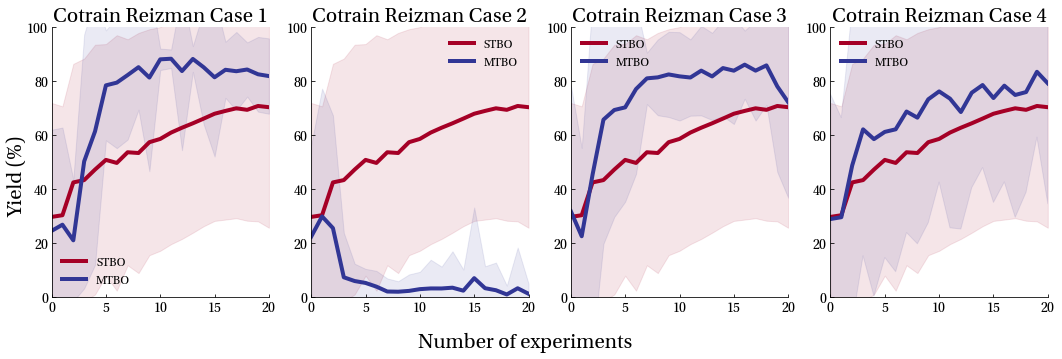

In [45]:
fig = plt.figure(figsize=(15,5))
fig.subplots_adjust(wspace=0.2, hspace=0.5)
k = 1
axis_fontsize=14
for i in range(1,5):
    ax = fig.add_subplot(1,4, k)
    stbo_exps = all_experiments_baumgartner_stbo
    stbo_exps_mixed = all_experiments_baumgartner_stbo_mixed
    mtbo_exps = all_experiments[f"results_baumgartner_suzuki_cotrain_reizman_suzuki_case_{i}"]
    make_comparison_plot(
        dict(results=stbo_exps, label="STBO", color="#a50026"),
#         dict(results=stbo_exps_mixed, label="STBO Mixed", color="#fdae61"),
        dict(
            results=mtbo_exps,
            label="MTBO",
            color="#313695"
        ),
        ax=ax
    )
    ax.set_title(f"Cotrain Reizman Case {i}", fontsize=21)
    ax.set_xlim(0,20)
    ax.tick_params('y', labelsize=axis_fontsize)
    xlabels = np.arange(0, 21, 5)
    ax.set_xticks(xlabels)
    ax.set_xticklabels(xlabels, fontsize=axis_fontsize)
    ax.set_ylim(0,100)
    remove_frame(ax, sides=["right", "top"])
    k+=1
# fig.suptitle("Baumgartner Optimization")
fig.supxlabel("Number of experiments", fontsize=21)
fig.supylabel("Yield (%)", fontsize=21)
fig.tight_layout()
fig.savefig("../figures/baumgartner_reizman_one_cotraining_optimization.png", dpi=300, transparent=True)
fig.savefig("../figures/baumgartner_reizman_one_cotraining_optimization.svg", transparent=True)

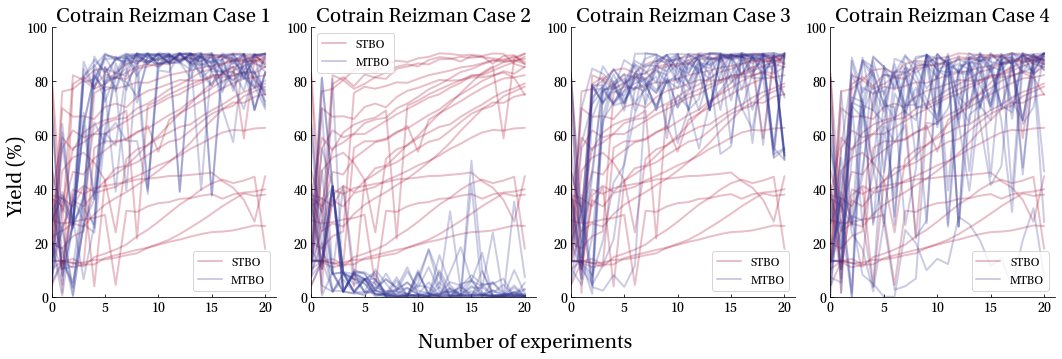

In [46]:
fig = plt.figure(figsize=(15,5))
fig.subplots_adjust(wspace=0.2, hspace=0.5)
k = 1
axis_fontsize=14
for i in range(1,5):
    ax = fig.add_subplot(1,4, k)
    stbo_exps = all_experiments_baumgartner_stbo
    stbo_exps_mixed = all_experiments_baumgartner_stbo_mixed
    mtbo_exps = all_experiments[f"results_baumgartner_suzuki_cotrain_reizman_suzuki_case_{i}"]
    make_comparison_plot(
        dict(results=stbo_exps, label="STBO", color="#a50026"),
        # dict(results=stbo_exps_mixed, label="STBO Mixed", color="#fdae61"),
        dict(
            results=mtbo_exps,
            label="MTBO",
            color="#313695"
        ),
        ax=ax,
        plot_type="repeats"
    )
    ax.set_title(f"Cotrain Reizman Case {i}", fontsize=21)
    ax.set_xlim(0,21)
    ax.tick_params('y', labelsize=axis_fontsize)
    xlabels = np.arange(0, 21, 5)
    ax.set_xticks(xlabels)
    ax.set_xticklabels(xlabels, fontsize=axis_fontsize)
    ax.set_ylim(0,100)
    remove_frame(ax, sides=["right", "top"])
    k+=1
# fig.suptitle("Baumgartner Optimization")
fig.supxlabel("Number of experiments", fontsize=21)
fig.supylabel("Yield (%)", fontsize=21)
fig.tight_layout()
# fig.savefig("../figures/baumgartner_reizman_one_cotraining_optimization_alternate.png", dpi=300, transparent=True)
# fig.savefig("../figures/baumgartner_reizman_one_cotraining_optimization_alternate.svg", transparent=True)

### Reizman

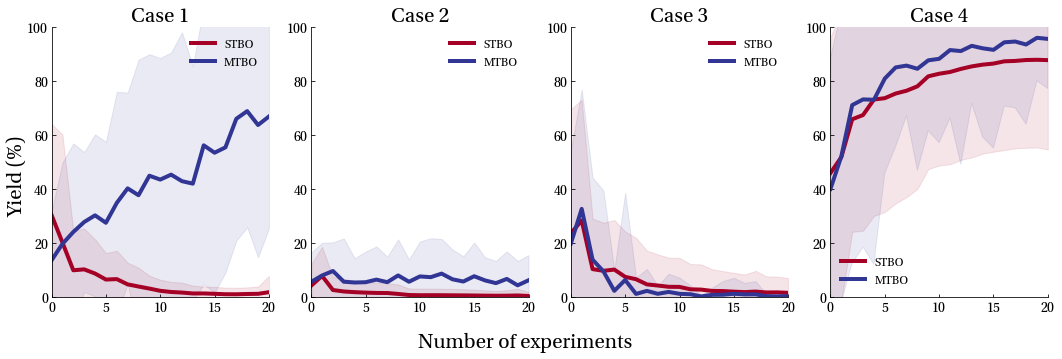

In [22]:
fig = plt.figure(figsize=(15,5))
fig.subplots_adjust(wspace=0.2, hspace=0.5)
k = 1
axis_fontsize=14
for i in range(1,5):
    ax = fig.add_subplot(1,4, k)
    stbo_exps = all_experiments_reizman_stbo[f"results_stbo_case_{i}"]
#             stbo_exps_mixed = all_experiments_reizman_stbo_mixed[f"results_stbo_mixed_case_{i}"]
    mtbo_exps = all_experiments[f"results_reizman_suzuki_{i}_cotrain_baumgartner_suzuki"]
    make_comparison_plot(
        dict(results=stbo_exps, label="STBO", color="#a50026"),
#                 dict(results=stbo_exps_mixed, label="STBO Mixed", color="#fdae61"),
        dict(results=mtbo_exps,label="MTBO",color="#313695"),
        ax=ax
    )
    ax.set_title(f"Case {i}", fontsize=21)
    ax.set_xlim(0,20)
    ax.tick_params('y', labelsize=axis_fontsize)
    xlabels = np.arange(0, 21, 5)
    ax.set_xticks(xlabels)
    ax.set_xticklabels(xlabels, fontsize=axis_fontsize)
    ax.set_ylim(0,100)
    remove_frame(ax, sides=["right", "top"])
    k+=1
# fig.suptitle("Reizman Optimization", fontsize=21)
fig.supxlabel("Number of experiments", fontsize=21)
fig.supylabel("Yield (%)", fontsize=21)
fig.tight_layout()
fig.savefig("../figures/reizman_baumgartner_one_cotraining_optimization.png", dpi=300)
fig.savefig("../figures/reizman_baumgartner_one_cotraining_optimization.svg", dpi=300)

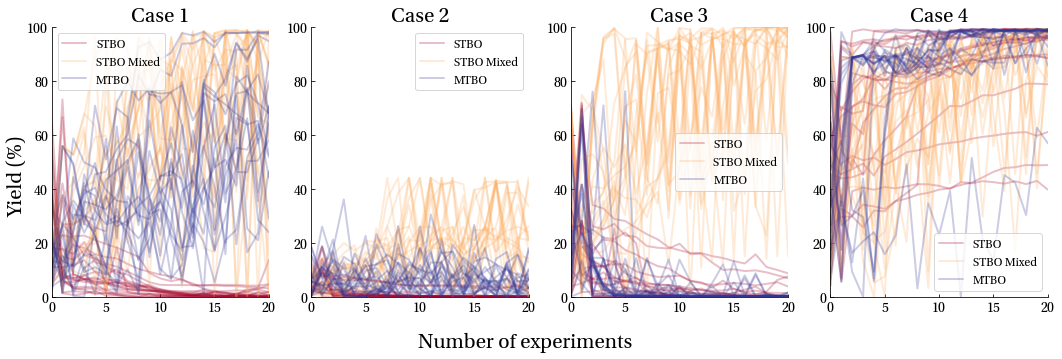

In [23]:
fig = plt.figure(figsize=(15,5))
fig.subplots_adjust(wspace=0.2, hspace=0.5)
k = 1
axis_fontsize=14
for i in range(1,5):
    ax = fig.add_subplot(1,4, k)
    stbo_exps = all_experiments_reizman_stbo[f"results_stbo_case_{i}"]
    stbo_exps_mixed = all_experiments_reizman_stbo_mixed[f"results_stbo_mixed_case_{i}"]
    mtbo_exps = all_experiments[f"results_reizman_suzuki_{i}_cotrain_baumgartner_suzuki"]
    make_comparison_plot(
        dict(results=stbo_exps, label="STBO", color="#a50026"),
        dict(results=stbo_exps_mixed, label="STBO Mixed", color="#fdae61"),
        dict(results=mtbo_exps,label="MTBO",color="#313695"),
        ax=ax,
        plot_type="repeats"
    )
    ax.set_title(f"Case {i}", fontsize=21)
    ax.set_xlim(0,20)
    ax.tick_params('y', labelsize=axis_fontsize)
    xlabels = np.arange(0, 21, 5)
    ax.set_xticks(xlabels)
    ax.set_xticklabels(xlabels, fontsize=axis_fontsize)
    ax.set_ylim(0,100)
    remove_frame(ax, sides=["right", "top"])
    
    k+=1
# fig.suptitle("Reizman Optimization", fontsize=21)
fig.supxlabel("Number of experiments", fontsize=21)
fig.supylabel("Yield (%)", fontsize=21)
fig.tight_layout()
# fig.savefig("../figures/reizman_baumgartner_one_cotraining_optimization.png", dpi=300)
# fig.savefig("../figures/reizman_baumgartner_one_cotraining_optimization.svg", dpi=300)

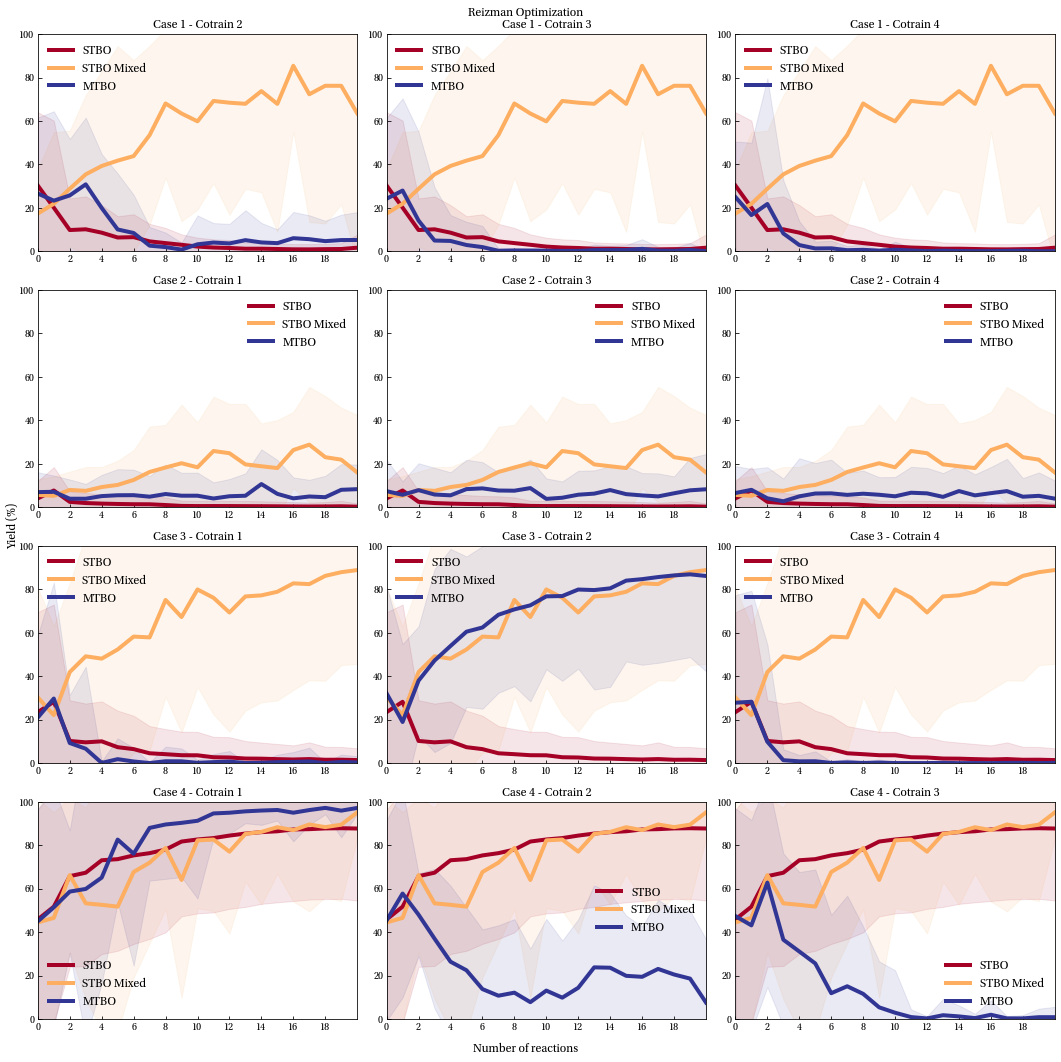

In [24]:
fig = plt.figure(figsize=(15,15))
fig.subplots_adjust(wspace=0.2, hspace=0.5)
k = 1
for i in range(1,5):
    for j in range(1,5):
        if i != j:
            ax = fig.add_subplot(4,3, k)
            stbo_exps = all_experiments_reizman_stbo[f"results_stbo_case_{i}"]
            # stbo_exps_mixed = all_experiments_reizman_stbo_mixed[f"results_stbo_mixed_case_{i}"]
            mtbo_exps = all_experiments[f"results_reizman_suzuki_case_{i}_cotrain_reizman_suzuki_case_{j}"]
            make_comparison_plot(
                dict(results=stbo_exps, label="STBO", color="#a50026"),
                dict(results=stbo_exps_mixed, label="STBO Mixed", color="#fdae61"),
                dict(results=mtbo_exps,label="MTBO",color="#313695"),
                ax=ax
            )
            ax.set_title(f"Case {i} - Cotrain {j}")
            ax.set_ylim(0,100)
            k+=1
fig.suptitle("Reizman Optimization")
fig.supxlabel("Number of reactions")
fig.supylabel("Yield (%)")
fig.tight_layout()
fig.savefig("../figures/reizman_reizman_one_cotraining_optimization.png", dpi=300)

### All combinations

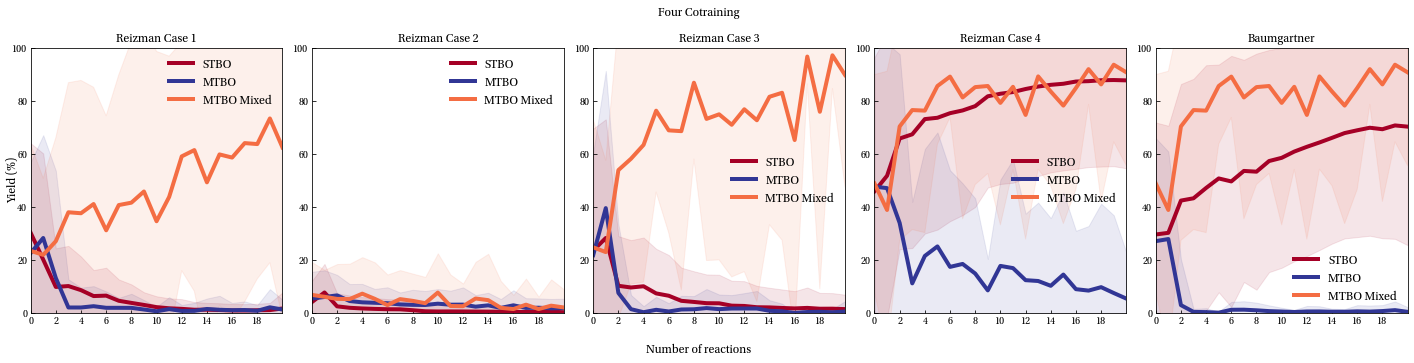

In [25]:
fig = plt.figure(figsize=(20,5))
fig.subplots_adjust(wspace=0.2, hspace=0.5)

# Reizman
k = 1
for i in range(1,5):
    ax = fig.add_subplot(1,5, k)
    stbo_exps = all_experiments_reizman_stbo[f"results_stbo_case_{i}"]
    mtbo_exps = all_experiments[f"results_reizman_suzuki_case_{i}"]
    mixed_mtbo_exps = all_experiments[
        f"results_multitask_four_cotraining_mixed_domain_reizman_suzuki_case_{i}"
    ]
    make_comparison_plot(
        dict(results=stbo_exps, label="STBO", color="#a50026"),
        dict(results=mtbo_exps,label="MTBO",color="#313695"),
        dict(results=mixed_mtbo_exps,label="MTBO Mixed",color="#F46D43"),
        ax=ax
    )
    ax.set_title(f"Reizman Case {i}")
    ax.set_xlim(0,20)
    ax.set_ylim(0,100)
    k+=1
    
# Baumgartner
ax = fig.add_subplot(1,5, 5)
stbo_exps = all_experiments_baumgartner_stbo
mtbo_exps = all_experiments[f"results_baumgartner_suzuki"]
mtbo_exps_mixed = all_experiments[f"results_multitask_four_cotraining_mixed_domain_baumgartner_suzuki"]
make_comparison_plot(
    dict(results=stbo_exps, label="STBO", color="#a50026"),
    dict(results=mtbo_exps,label="MTBO",color="#313695"),
    dict(results=mixed_mtbo_exps,label="MTBO Mixed",color="#F46D43"),
    ax=ax
)


# Formatting
ax.set_title(f"Baumgartner")
ax.set_xlim(0,20)
ax.set_ylim(0,100)
fig.suptitle("Four Cotraining")
fig.supxlabel("Number of reactions")
fig.supylabel("Yield (%)")
fig.tight_layout()
fig.savefig("../figures/multitask_four_cotraining_results.png", dpi=300)

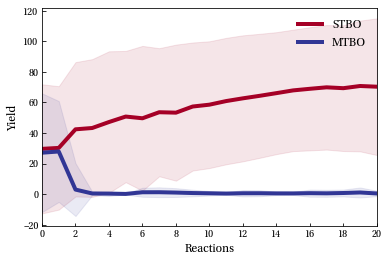

In [26]:
fig, ax = plt.subplots(1)
stbo_exps = all_experiments_baumgartner_stbo
mtbo_exps = all_experiments[f"results_baumgartner_suzuki"]
make_comparison_plot(
    dict(results=stbo_exps, label="STBO", color="#a50026"),
    dict(
        results=mtbo_exps,
        label="MTBO",
        color="#313695"
    ),
    ax=ax
)
ax.set_xlim(0,20)
fontdict = fontdict={"size":12}
ax.set_xticks(np.arange(0, 22, 2).astype(int))
ax.set_ylabel('Yield', fontdict=fontdict)
ax.set_xlabel('Reactions', fontdict=fontdict)
fig.savefig("../figures/baumgartner_suzuki_reizman_four_cotraining.png", dpi=300, transparent=False)

In [27]:
def calculate_means_std(experiments, cuttoff):
    yields = [
        exp.data["yld"].iloc[:cutoff].max() 
        for exp in experiments
    ]
    return np.mean(yields), np.std(yields)
  

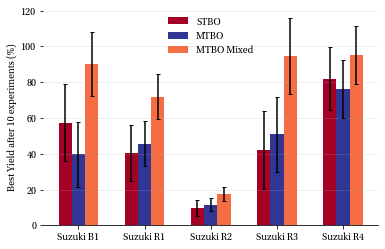

In [28]:
cutoff = 10
labels = []
stbo_means = []
mtbo_means = []
mtbo_mixed_means = []
stbo_stds = []
mtbo_stds = []
mtbo_mixed_stds = []

# Baumgartner
labels.append("Suzuki B1")
mean, std = calculate_means_std(
    all_experiments_baumgartner_stbo, cutoff
)
stbo_means.append(mean)
stbo_stds.append(std)


mean, std = calculate_means_std(
    all_experiments[f"results_baumgartner_suzuki"], cutoff
)
mtbo_means.append(mean)
mtbo_stds.append(std)

mean, std = calculate_means_std(
    all_experiments[
        "results_multitask_four_cotraining_mixed_domain_baumgartner_suzuki"
    ], 
    cutoff
)
mtbo_mixed_means.append(mean)
mtbo_mixed_stds.append(std)


# Reizman
results = [
    calculate_means_std(
        all_experiments_reizman_stbo[f"results_stbo_case_{i}"], cutoff
    ) 
    for i in range(1,5)
]
stbo_means.extend([r[0] for r in results])
stbo_stds.extend([r[1] for r in results])


results = [
    calculate_means_std(
        all_experiments[f"results_reizman_suzuki_case_{i}"], cutoff
    ) 
    for i in range(1,5)
]
mtbo_means.extend([r[0] for r in results])
mtbo_stds.extend([r[1] for r in results])

results =  [
    calculate_means_std(
        all_experiments[
            f"results_multitask_four_cotraining_mixed_domain_reizman_suzuki_case_{i}"
        ], 
        cutoff
    ) 
    for i in range(1,5)
]
mtbo_mixed_means.extend([r[0] for r in results])
mtbo_mixed_stds.extend([r[1] for r in results])
labels.extend([f"Suzuki R{i}" for i in range(1,5)])

# Bar plot
fig, ax = plt.subplots(1)
x = np.arange(len(labels))
width = 0.2
caps = 2.0
ax.bar(x - width, stbo_means, width, yerr=stbo_stds, capsize=caps, label="STBO", color="#a50026")
ax.bar(x, mtbo_means, width, yerr=mtbo_stds, capsize=caps, label="MTBO", color="#313695")
ax.bar(x + width, mtbo_mixed_means, width, yerr=mtbo_stds, capsize=caps, label="MTBO Mixed", color="#F46D43")
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylabel("Best Yield after 10 experiments (%)")
# ax.tick_params(length=0)
ax.grid(axis="y", alpha=0.25)
ax.legend(framealpha=False)
remove_frame(ax)

# Save plot
fig.savefig("../figures/comparison_plot.png", dpi=300, transparent=True)

## Visualize Catalyst Choices

In [29]:
def visualize_catalyst_choice(experiments):
    avg_yields = [
        exp.data.groupby("catalyst_smiles")["yld"].mean()
        for exp in experiments
    ]
    df =pd.concat(avg_yields, axis=1).fillna(0)
    avg_yields = df.mean(axis=1)
    std_yields = df.std(axis=1)
    cat_counts = [
        exp.data["catalyst_smiles"].value_counts()
        for exp in experiments
    ]
    df =pd.concat(cat_counts, axis=1).fillna(0)
    cat_counts = df.mean(axis=1)
    # cat_counts = exps[0].data["catalyst_smiles"].value_counts()
    return Chem.Draw.MolsToGridImage(
        [Chem.MolFromSmiles(smiles) for smiles in cat_counts.index],
        legends=[f"{v:.0f} (Yield {avg_yields[smiles]:.0f}+/-{std_yields[smiles]:.0f}%)" for smiles, v in zip(cat_counts.index, cat_counts)]
    )


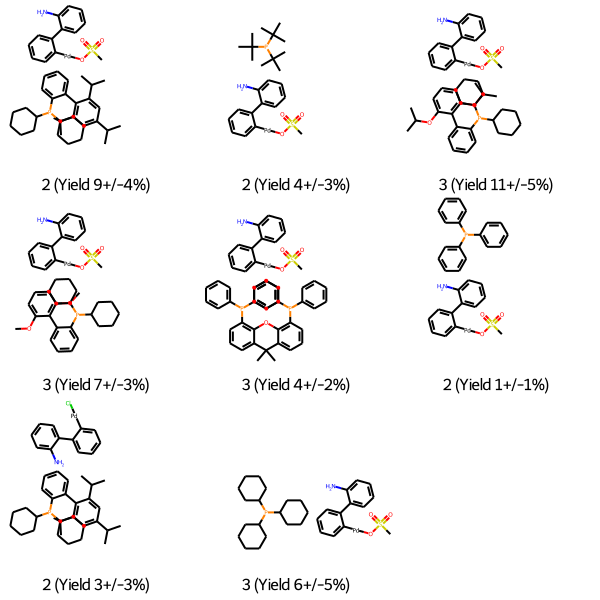

In [30]:
visualize_catalyst_choice(all_experiments[f"results_reizman_suzuki_2_cotrain_baumgartner_suzuki"])

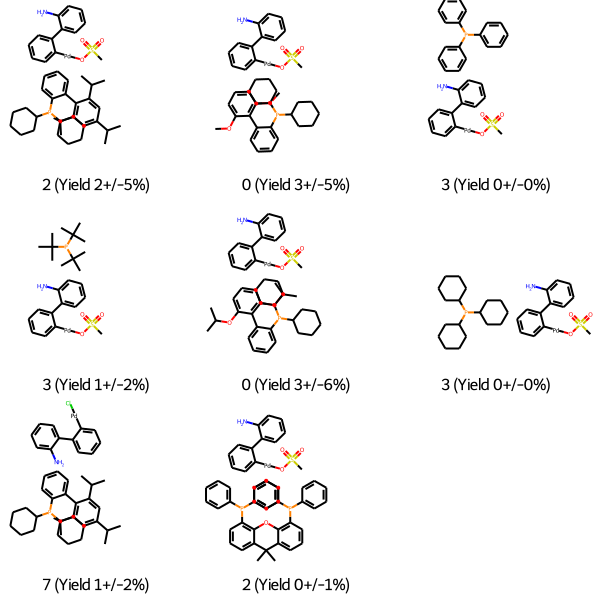

In [31]:
visualize_catalyst_choice(all_experiments_reizman_stbo[f"results_stbo_case_2"])

In [32]:
# exp = SuzukiEmulator.load(model_name="reziman_suzuki_case_4", save_dir="../data/reizman_suzuki/emulator_case_4")
data_path = Path("../data/reizman_suzuki/ord/reizman_suzuki_case_2.pb")
ds = get_suzuki_dataset(
    data_path,
    split_catalyst=False,
    print_warnings=False,
)

NameError: name 'get_suzuki_dataset' is not defined

In [ ]:
catalysts = ds["catalyst_smiles"].value_counts()
df = pd.DataFrame(ds.to_numpy(), columns=[c[0] for c in ds.columns])
df["yld"] = df["yld"].astype(float)
catalysts_yield = df.groupby("catalyst_smiles")["yld"].mean()
Chem.Draw.MolsToGridImage(
    [Chem.MolFromSmiles(smiles) for smiles in catalysts.index],
    legends=[f"{v} (Avg Yield {catalysts_yield[smiles]:.1f}%)" for smiles, v in zip(catalysts.index, catalysts)]
)

# Kinetic Models

## Load Kinetic Model Data

In [47]:
def open_json(file:str):
    with open(file, "r") as f:
        return json.load(f)
    
cases = {1: MIT_case1, 2: MIT_case2, 3: MIT_case3, 4: MIT_case4, 5: MIT_case5}

In [48]:
# Load experiment metadata
metadata = []
experiments = {}

# STBO
kinetics_path = pathlib.Path("../data/kinetic_models/stbo")

for case in range(1,6):
    exp_dirs = kinetics_path.glob(f"{case}/*")
    for exp_dir in exp_dirs:
        if not os.path.isdir(exp_dir):
            continue
        exp_id = exp_dir.parts[-1]
        args = open_json(exp_dir/ "args.json")
        args["exp_id"] = exp_id
        exps = [open_json(exp) for exp in exp_dir.glob("repeat_*.json")]
        exps = [cases[case].from_dict(exp["experiment"]) for exp in exps]
        experiments[exp_id] = exps
        metadata.append(args)

# MTBO
kinetics_path = pathlib.Path("../data/kinetic_models/mtbo")
for case in range(1,6):
    exp_dirs = kinetics_path.glob(f"case_1_ct_{case}/*")
    for exp_dir in exp_dirs:
        if not os.path.isdir(exp_dir):
            continue
        exp_id = exp_dir.parts[-1]
        args = open_json(exp_dir/ "args.json")
        args["ct_case"] = args["ct_cases"][0]
        args["exp_id"] = exp_id
        exps = [open_json(exp) for exp in exp_dir.glob("repeat_*.json")]
        exps = [cases[case].from_dict(exp["experiment"]) for exp in exps]
        experiments[exp_id] = exps
        metadata.append(args)
km_df = pd.DataFrame(metadata)

## Runtime

In [ ]:
acquisition_function_times = {}
for name, df in km_df.groupby("acquisition_function"):
    n = 0
    tbar = 0
    for _, row in df.iterrows():
        times = np.mean(
            [
                exp.data["computation_t"].sum() 
                for exp in experiments[row["exp_id"]]
            ]
        )
        n+=1
        tbar = times/n+(n-1)/n*tbar
    acquisition_function_times[name] = tbar / 60
# In minutes
acquisition_function_times

/Users/Kobi/Library/Caches/pypoetry/virtualenvs/multitask-k0YbXS9f-py3.9/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/Kobi/Library/Caches/pypoetry/virtualenvs/multitask-k0YbXS9f-py3.9/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


{'EI': nan, 'qNEI': nan}

## Optimzation Curves

In [ ]:
def kinetic_model_comparison(df: pd.DataFrame, comparison_dimension: str, comparison_label:str, units:str=""):
    fig = plt.figure(figsize=(15,5))
    fig.subplots_adjust(wspace=0.25, hspace=0.5)
    k = 1
    axis_fontsize=14
    colors = ["#a50026", "#fdae61", "#313695"]
    base_ax = None
    extra_axes = []
    for case, sub_df in df.groupby("case"):
        ax = fig.add_subplot(1,5, k)
        if k == 1:
            base_ax = ax
        else:
            # base_ax.get_shared_x_axes().join(ax)
            extra_axes.append(ax)
        args = []
        for i, (level, exp_df) in enumerate(sub_df.groupby(comparison_dimension)):
            exps = []
            for _, row in exp_df.iterrows():
                exps.extend(experiments[row["exp_id"]])
            args.append(
                dict(
                    results=exps,
                    label=f"""{comparison_label}={level}{units}""",
                    color=colors[i]
                )
            )
        ax.set_title(f"""K{case}""", fontsize=21)
        make_comparison_plot(*tuple(args), ax=ax, plot_type="average")
        ax.set_xlim(0,20)
        ax.tick_params('y', labelsize=axis_fontsize)
        xlabels = np.arange(0, 21, 5)
        ax.set_xticks(xlabels)
        ax.set_xticklabels(xlabels, fontsize=axis_fontsize)
        ax.set_ylim(0,100)
        remove_frame(ax, sides=["right", "top"])
        k += 1
    fig.supylabel("Yield (%)")
    fig.supxlabel("Number of experiments")
    fig.tight_layout()
    return fig

### Compare STBO and MTBO

In [ ]:
strategy_comparison = km_df[
    (km_df["acquisition_function"]=="EI") &
    (km_df["num_initial_experiments"]==0) &
    (km_df["brute_force_categorical"]==False) &
    # (km_df["strategy"]=="STBO") &
    (km_df["noise_type"]=="constant") &
    (km_df["noise_level"]==5.0)
]
fig = kinetic_model_comparison(strategy_comparison, "strategy", "Strategy", "")

### Effect of Noise in Single Task Bayesian Optimization

In [ ]:
noise_comparison = km_df[
    (km_df["acquisition_function"]=="EI") &
    (km_df["num_initial_experiments"]==0) &
    (km_df["brute_force_categorical"]==False) &
    (km_df["strategy"]=="STBO") &
    (km_df["noise_type"]=="constant")
]
fig = kinetic_model_comparison(noise_comparison, "noise_level", "Noise", "%")
fig.savefig("../figures/kinetic_models_stbo_noise_effects_ei.png", dpi=300)

In [ ]:
noise_comparison = km_df[
    (km_df["acquisition_function"]=="EI") &
    (km_df["num_initial_experiments"]==0) &
    (km_df["brute_force_categorical"]==False) &
    (km_df["strategy"]=="MTBO") &
    (km_df["noise_type"]=="constant") &
    (km_df["ct_case"]==2)
]
fig = kinetic_model_comparison(noise_comparison, "noise_level", "Noise", "%")
fig.savefig("../figures/kinetic_models_mtbo_noise_effects_ei.png", dpi=300)

In [ ]:
noise_comparison = km_df[
    (km_df["acquisition_function"]=="qNEI") &
    (km_df["num_initial_experiments"]==0) &
    (km_df["brute_force_categorical"]==False) &
    (km_df["strategy"]=="STBO") &
    (km_df["noise_type"]=="constant")
]
fig = kinetic_model_comparison(noise_comparison, "noise_level", "Noise", "%")
fig.savefig("../figures/kinetic_models_stbo_noise_effects_qnei.png", dpi=300)

In [ ]:
noise_comparison = km_df[
    (km_df["acquisition_function"]=="qNEI") &
    (km_df["num_initial_experiments"]==0) &
    (km_df["brute_force_categorical"]==False) &
    (km_df["strategy"]=="MTBO") &
    (km_df["noise_type"]=="constant")
]
fig = kinetic_model_comparison(noise_comparison, "noise_level", "Noise", "%")
# fig.savefig("../figures/kinetic_models_stbo_noise_effects_qnei.png", dpi=300)

### Number of initial experiments

In [ ]:
num_initial_exps = km_df[
    (km_df["acquisition_function"]=="qNEI") &
    (km_df["brute_force_categorical"]==False) &
    (km_df["strategy"]=="STBO") &  
    (km_df["noise_level"]==5.0) &
    (km_df["noise_type"]=="constant")
]
fig = kinetic_model_comparison(num_initial_exps, "num_initial_experiments", "N")
# fig.savefig("../figures/kinetic_models_stbo_initial_experiments_qnei_low_noise.png", dpi=300)

In [ ]:
experiments["b870ea66-02bc-4163-969d-f3a3ce93a920"][0].domain

In [ ]:
noise_comparison = km_df[
    (km_df["acquisition_function"]=="qNEI") &
    (km_df["brute_force_categorical"]==False) &
    (km_df["strategy"]=="MTBO") &  
    (km_df["noise_level"]==5.0) &
    (km_df["noise_type"]=="constant") &
    (km_df["ct_num_initial_experiments"]==10) &
    (km_df["ct_brute_force_categorical"]==False) &
]
fig = kinetic_model_comparison(noise_comparison, "num_initial_experiments", "N")
# fig.savefig("../figures/kinetic_models_stbo_initial_experiments_qnei_low_noise.png", dpi=300)

In [ ]:
noise_comparison = km_df[
    (km_df["acquisition_function"]=="qNEI") &
    (km_df["brute_force_categorical"]==False) &
    (km_df["strategy"]=="STBO") &  
    (km_df["noise_level"]==10.0)
]
fig = kinetic_model_comparison(noise_comparison, "num_initial_experiments", "N")
# fig.savefig("../figures/kinetic_models_stbo_initial_experiments_qnei_high_noise.png", dpi=300)

In [ ]:
noise_comparison = km_df[
    (km_df["acquisition_function"]=="qNEI") &
    (km_df["brute_force_categorical"]==False) &
    (km_df["strategy"]=="MTBO") &  
    (km_df["noise_level"]==0.0) &
    (km_df["noise_type"]=="constant") &
    (km_df["ct_case"]==2)
]
fig = kinetic_model_comparison(noise_comparison, "num_initial_experiments", "N")
# fig.savefig("../figures/kinetic_models_stbo_initial_experiments_qnei_low_noise.png", dpi=300)

In [ ]:
km_df.columns

At higher noise levels, having 5 initial experiments can help achieve higher yields more consistently?

### GP Type

In [ ]:
gp_kernel_comparison = km_df[
    (km_df["acquisition_function"]=="qNEI") &
    (km_df["num_initial_experiments"]==0) &
    (km_df["strategy"]=="STBO") &  
    (km_df["noise_level"]==1.0)
]
fig = kinetic_model_comparison(gp_kernel_comparison, "brute_force_categorical", "Mixed")
# fig.savefig("../figures/kinetic_models_stbo_initial_experiments_qnei_high_noise.png", dpi=300)

In [ ]:
km_df[km_df["brute_force_categorical"]==True]

## Catalyst Selection

In [ ]:
n_initial = 10
stbo_ten =km_df[
    (km_df["acquisition_function"]=="qNEI") &
    (km_df["brute_force_categorical"]==False) &
    (km_df["strategy"]=="STBO") &  
    (km_df["noise_level"]==5.0) &
    (km_df["noise_type"]=="constant") &
    (km_df["num_initial_experiments"]==n_initial)
]["exp_id"]
counts = [len(experiments[exp_id][0].data["cat_index"].unique()) for exp_id in stbo_ten]
fig, ax  = plt.subplots(1)
counts_frequency = pd.Series(counts).value_counts()/ 100
counts_frequency.sort_index().plot.bar(ax=ax)
ax.tick_params(axis="y", direction="in")
ax.set_ylabel("Frequency")
ax.set_xlabel("Number of catalysts selected during initial design and optimization")
ax.set_title(f"{n_initial} initial experiments")
fig.savefig("../figures/initial_experiments_comparison.png", dpi=300)

In [ ]:
experiments[exp_id][0].domain

In [ ]:
case_1 = km_df[km_df["case"]==1]["exp_id"]
case_1_groups = [experiments[exp_id][0].data for exp_id in case_1 if len(experiments[exp_id])>0]
case_1_cats = pd.concat(case_1_groups).groupby("cat_index")["y"].mean()
case_1_cats

In [ ]:
case_1_cats.plot.bar()

In [ ]:
parameters = {
    "case": [1,2,3,4,5],
    "ct_case": [1,2,3,4,5],
    "ct_strategy": ["STBO", "LHS"],
    "noise_level": [0.0, 1.0, 10.0],
    "num_initial_experiments": [0, 5],
    "max_ct_experiments": [20, 50],
    "acquisition_function": ["qNEI", "EI"]
}
total_exps = 20
for param in parameters.values():
    total_exps *= len(param)
print("Total experiments:", total_exps)
print(f"Total days to complete in sequence assuming ~1 minute per experiment: {total_exps/60/24:.01f} days")
print(f"Total days to complete in parallel (3 at a time, each taking 1 minutes): {total_exps/60/24/3:.01f}")
print(f"Total days to complete in parallel (6 at a time, each taking 2 minutes): {total_exps*1/60/24/6:.01f}")

In [ ]:
2.1*24*2.18